# Vehicle Detection

### Vehicle Classifier

Firstly, we load an example image and resize it to 32x32

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

from skimage.feature import hog
from sklearn.preprocessing import normalize
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lesson_functions import *



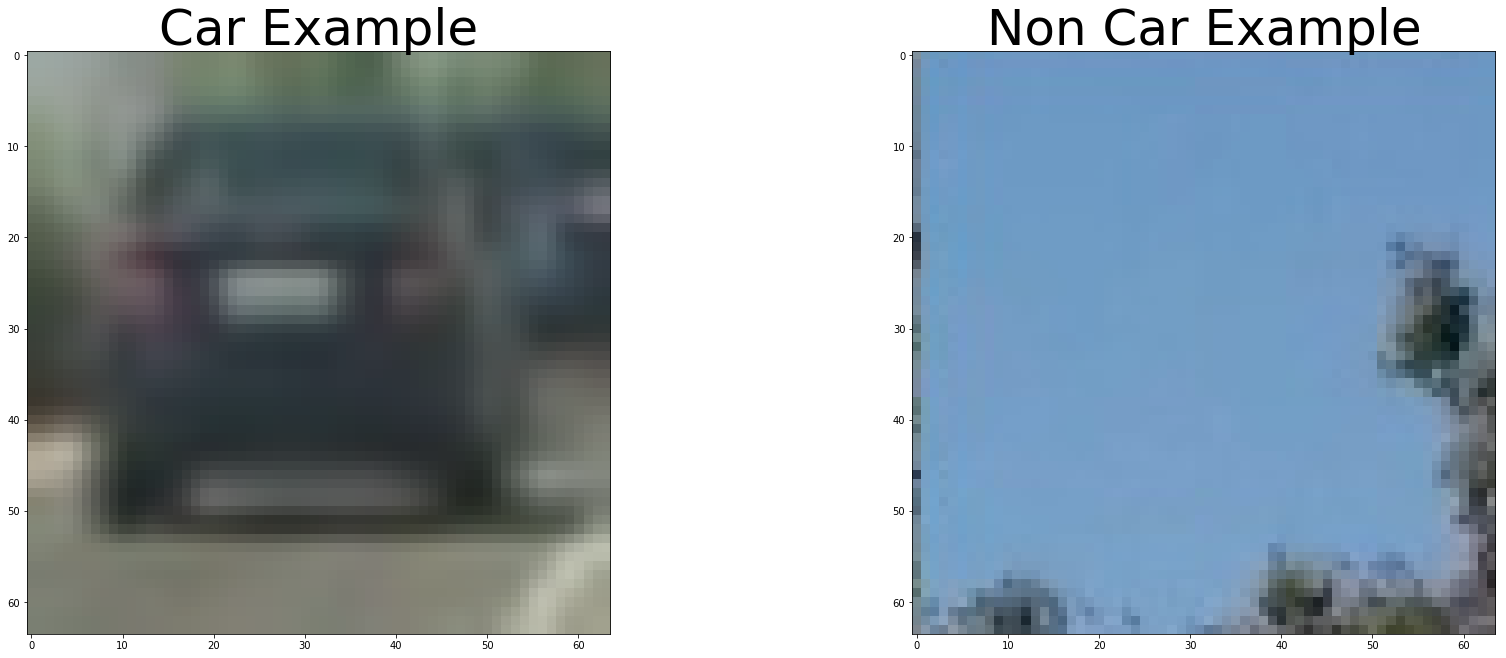

In [2]:
image_car = mpimg.imread('vehicles/GTI_Far/image0000.png')
image_not_car = mpimg.imread('non-vehicles/Extras/extra1.png')

%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_car)
ax1.set_title('Car Example', fontsize=50)
ax2.imshow(image_not_car)
ax2.set_title('Non Car Example', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



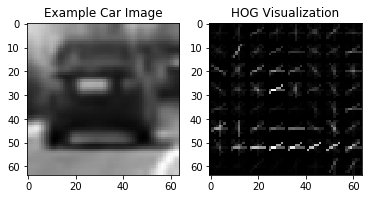

In [3]:
gray = cv2.cvtColor(image_car, cv2.COLOR_RGB2GRAY)

features, hog_image = get_hog_features(gray, orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


In [4]:
def norm(array):
    
    amin = np.amin(array)
    amax = np.amax(array)
    
    if (amax - amin == 0):
        return [0 for item in array]
    else:
        return [(item - amin) / (amax - amin) for item in array]


def extract_features(images):
    
    features = []
    
    for image in images:

        if (isinstance(image, str)) :
            image = mpimg.imread(image)
        
        file_features = []
        
        image = cv2.resize(image, (32, 32))
        
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray_hog_features = norm(get_hog_features(gray, orient=8))
        
        
        file_features.append(gray_hog_features)

        features.append(np.concatenate(file_features))
        
    # Return list of feature vectors
    return features

Extract features of the image

In [5]:
print(extract_features(['vehicles/GTI_Far/image0295.png']))

[array([  7.59415139e-03,   5.58527730e-03,   7.72445601e-03,
         7.12187464e-02,   4.16394351e-02,   1.53324912e-02,
         1.60711733e-03,   2.04331309e-03,   5.16125858e-02,
         3.43921945e-02,   2.79232121e-02,   2.09382197e-01,
         7.08702856e-02,   6.99392938e-03,   1.16103111e-03,
         0.00000000e+00,   6.55582191e-02,   7.92328188e-02,
         6.69828829e-02,   1.82971339e-01,   1.73980659e-01,
         5.54094905e-02,   7.09270482e-02,   1.15978259e-01,
         5.37192443e-02,   3.60253764e-02,   3.01891484e-02,
         1.00000000e+00,   2.91412500e-01,   3.11331202e-02,
         1.22085797e-02,   2.18000954e-02,   3.71944115e-02,
         2.47846027e-02,   2.01227555e-02,   1.50890475e-01,
         5.10723988e-02,   5.04014831e-03,   8.36692606e-04,
         0.00000000e+00,   3.85967507e-03,   2.48280641e-03,
         1.95300517e-02,   1.37846279e-01,   2.36403821e-01,
         1.72210394e-02,   1.15485120e-02,   2.59560811e-03,
         3.87125669e-02

#### Data Preparation

In [6]:
# Divide up into cars and notcars
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

# Reduce the sample size because HOG features are slow to compute
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

t=time.time()

car_features = extract_features(cars)
notcar_features = extract_features(notcars)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')


# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

16.33 Seconds to extract HOG features...


#### Train the model

In [7]:
print('Feature vector length:', len(X_train[0]))
print('Train data set size:', len(X_train))

# Use a linear SVC, add penaty for false positive
svc = MLPClassifier()#DecisionTreeClassifier()#LinearSVC(class_weight={0: 1, 1: 20})
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

Feature vector length: 288
Train data set size: 14462
3.37 Seconds to train SVC...


#### Test model

In [9]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

y_test_car = y_test[y_test == 1]
X_test_car = X_test[y_test == 1]

print('Test Accuracy for Car of SVC = ', round(svc.score(X_test_car, y_test_car), 4))

# Check the prediction time for a single sample

n_predict = 100
print('My SVC predicts: \n', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: \n', y_test[0:n_predict])


Test Accuracy of SVC =  0.9864
Test Accuracy for Car of SVC =  0.9837
My SVC predicts: 
 [ 1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  1.  1.  1.  0.  0.  1.  0.  0.
  1.  0.  0.  1.  1.  0.  1.  1.  1.  1.  0.  0.  1.  0.  0.  0.  1.  1.
  0.  1.  1.  0.  1.  1.  0.  1.  0.  1.  1.  0.  1.  1.  1.  0.  1.  0.
  0.  0.  1.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  1.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.  0.  0.  1.  0.  1.
  0.  0.  1.  1.  1.  0.  0.  1.  0.  1.]
For these 100 labels: 
 [ 1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  1.  1.  1.  0.  0.  1.  0.  0.
  1.  0.  0.  1.  1.  0.  1.  1.  1.  1.  0.  0.  1.  0.  0.  0.  1.  1.
  0.  1.  1.  0.  1.  1.  0.  1.  0.  1.  1.  0.  1.  1.  1.  0.  1.  0.
  0.  0.  1.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  1.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.  0.  0.  1.  0.  1.
  0.  0.  1.  1.  1.  0.  0.  1.  0.  1.]


### Sliding Windows Detection

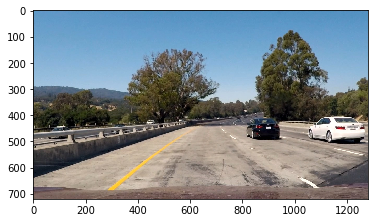

In [14]:
image = mpimg.imread('test_images/test1.jpg')

%matplotlib inline

plt.imshow(image)

217


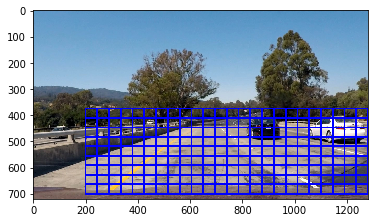

In [15]:
def search_windows(img, windows, clf, scaler):
    
    if (len(windows) == 0):
        return []

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    
    test_images = [cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) for window in windows]
    
    features = extract_features(test_images)
    X = scaler.transform(features)

    prediction = clf.predict(X)
    
    return [window for (window, pred) in zip(windows, prediction) if pred == 1]    

windows = []

windows += slide_window(image, x_start_stop=[200, 1280], y_start_stop=[375, 700], xy_window=(90, 72), xy_overlap=(0.5, 0.5))
windows += slide_window(image, x_start_stop=[200, 1280], y_start_stop=[375, 700], xy_window=(180, 144), xy_overlap=(0.5, 0.5))



print(len(windows))

hot_windows = search_windows(image, windows, svc, X_scaler)                       

window_img = draw_boxes(np.copy(image), windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

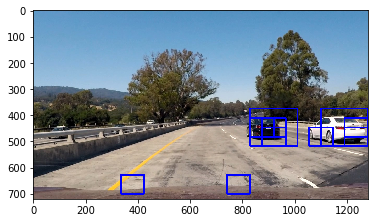

In [16]:
window_img = draw_boxes(np.copy(image), hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

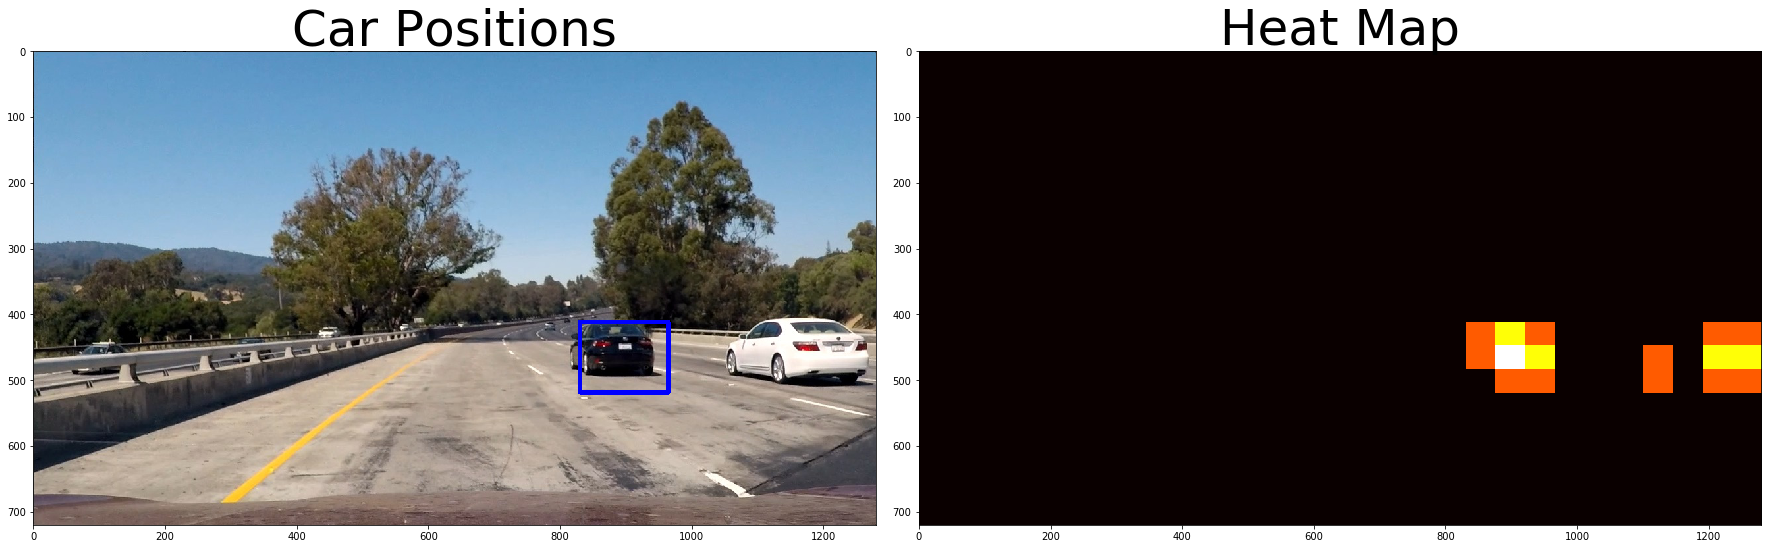

In [19]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)


%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=50)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Pipeline

In [20]:
def label_to_box(labels):
    
    car_boxes = []
    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # a car must in good size...
        if ( 0.5 < (bbox[1][0] - bbox[0][0]) / (bbox[1][1] - bbox[0][1]) < 4) :
        
            car_boxes.append((bbox[0], bbox[1]));
            
    return car_boxes        
    

def draw_labeled_bboxes(img, labels):
   
    car_boxes = label_to_box(labels)
    
    for box in car_boxes:
        cv2.rectangle(img, box[0], box[1], (0,0,255), 4)

    # Return the image
    return img

In [21]:
def detect_car(image): 
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    hot_windows = search_windows(image, windows, svc, X_scaler)
    heat = add_heat(heat, hot_windows)
    heat = apply_threshold(heat, 1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
        
    draw_img = draw_labeled_bboxes(image, labels)
    
    return image

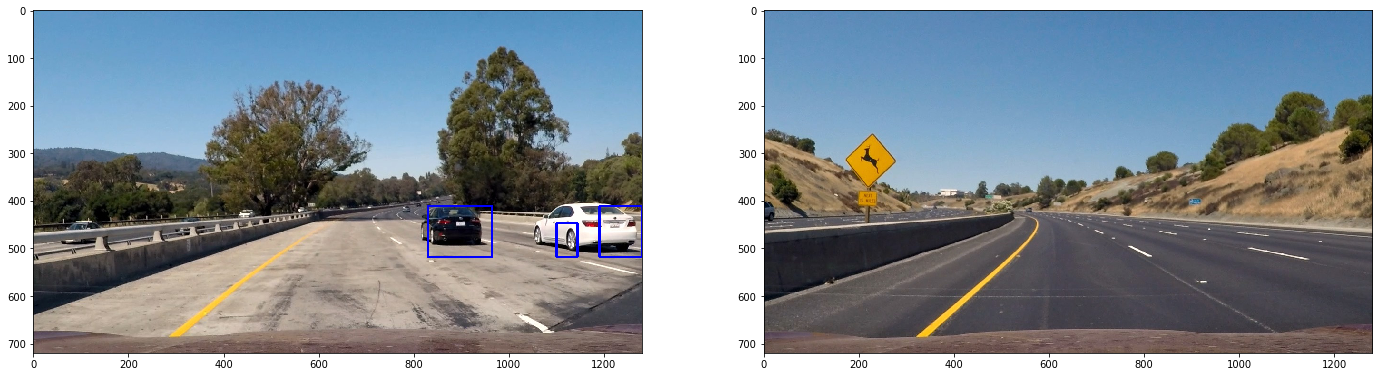

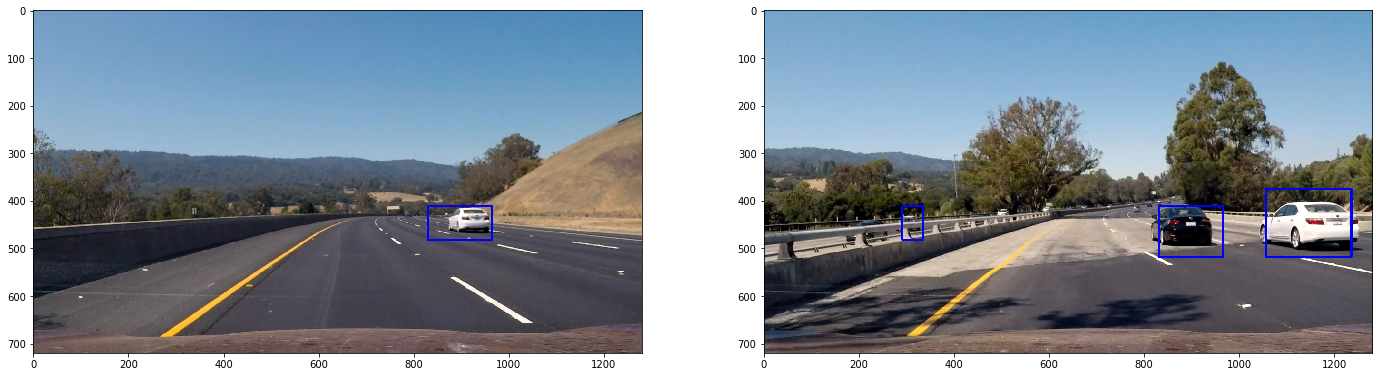

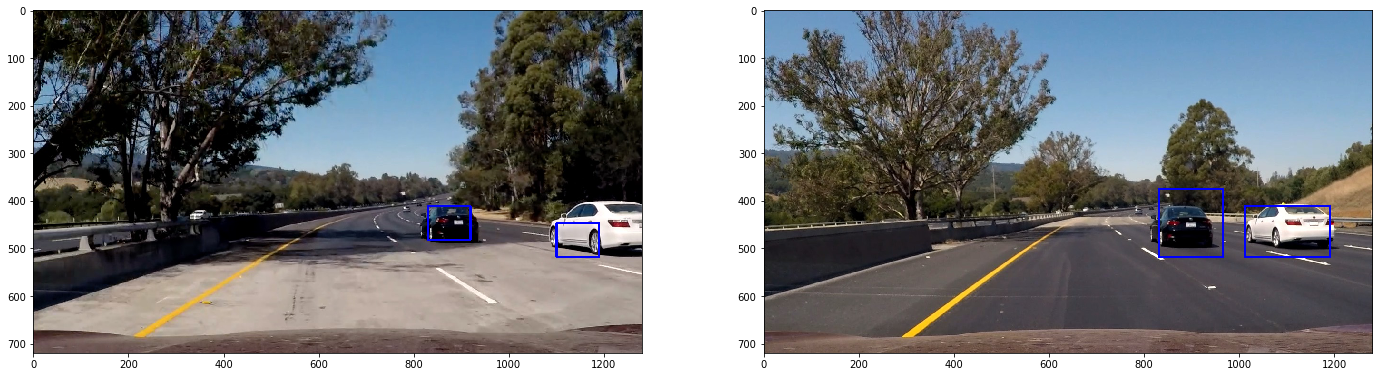

In [22]:
for i in range(1, 7, 2):
    image1 = mpimg.imread('test_images/test' + str(i) + '.jpg')
    detect_car(image1)
    
    image2 = mpimg.imread('test_images/test' + str(i+1) + '.jpg')
    detect_car(image2)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(image1)
    ax2.imshow(image2)


### Detect Vehicles in Video

In [29]:
windows_last_frames = []

def get_overlap_heat(new_hot_windows):
    
    global heat_last_10
    
    windows_last_frames.insert(0, new_hot_windows)
    if (len(windows_last_frames) > 7):
        windows_last_frames.pop()
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for w in windows_last_frames:
        heat = add_heat(heat, w)
        
    heat = apply_threshold(heat, 1.5 * len(windows_last_frames))
    heatmap = np.clip(heat, 0, 255)
        
    return heatmap


def detect_car_video(image):
    
    hot_windows = search_windows(image, windows, svc, X_scaler)

    heatmap = get_overlap_heat(hot_windows)

    labels = label(heatmap)
        
    draw_img = draw_labeled_bboxes(image, labels)
                
    return image


In [30]:
#print(detecting_cars_boxes)
#print(windows)

In [31]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

my_count = 0

white_output = 'project_video_detected.mp4'
clip1 = VideoFileClip('./project_video.mp4')

white_clip = clip1.fl_image(detect_car_video) 
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video project_video_detected.mp4
[MoviePy] Writing video project_video_detected.mp4


100%|█████████▉| 1260/1261 [02:46<00:00,  7.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_detected.mp4 

Wall time: 2min 47s
